## EDA of data

## Imports

In [1]:
import library as lb

import random
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

## Load Data

In [2]:
genes = pd.read_hdf('./data/train_cite_inputs.h5')
proteins = pd.read_hdf('./data/train_cite_targets.h5')
meta = pd.read_csv('./data/metadata.csv')

## Font defaults for visualizations

In [3]:
font_title_defaults = {'fontsize': 36,
                   'color': 'black',
                   'alpha': 1,
                   'horizontalalignment': 'center',
                   'rotation': 0,
                   'family': 'serif'}

font_xlabel_defaults = {'fontsize': 24,
                   'color': 'black',
                   'alpha': 1,
                   'horizontalalignment': 'center',
                   'rotation': 0,
                   'family': 'serif'}

font_ylabel_defaults = {'fontsize': 24,
                   'color': 'black',
                   'alpha': 1,
                   'horizontalalignment': 'center',
                   'rotation': 90,
                   'family': 'serif'}

## Initial EDA

### Consider the cells

In [4]:
genes.shape, proteins.shape, meta[meta['technology'] == 'citeseq'].shape

((70988, 22050), (70988, 140), (119651, 5))

The shape of the predictors and targets looks good. They have the same number of cells.
The metadata contains information for both the public train and the private test data sets.

#### Check for all zero columns

In [5]:
genes_with_no_occurence = [gene for gene in genes.columns if genes[gene].sum() == 0]

In [6]:
len(genes_with_no_occurence)

449

There are 449 genes that never occur and represent all zero columns. These can be droped.

In [7]:
genes_to_keep = [gene for gene in genes.columns if genes[gene].sum() != 0]
genes = genes.loc[:, genes_to_keep]

#### Check for all zero rows

In [8]:
cells_with_no_occurence = [cell for cell in genes.T.columns if genes.T[cell].sum() == 0]

In [9]:
cells_with_no_occurence

[]

All the cells have some recorded activity.

In [10]:
duplicates = genes.duplicated()
duplicates.head()

cell_id
45006fe3e4c8    False
d02759a80ba2    False
c016c6b0efa5    False
ba7f733a4f75    False
fbcf2443ffb2    False
dtype: bool

In [11]:
sum(duplicates.values)

0

There are no duplicated cells.

### Meta EDA

In [12]:
cells = [True if cell in genes.index else False for cell in meta['cell_id']]

In [13]:
sum(cells)

70988

In [14]:
meta = meta[cells]

In [15]:
meta.set_index('cell_id', inplace = True)

In [16]:
meta['technology'].unique()

array(['citeseq'], dtype=object)

In [17]:
meta.drop(columns = ['technology'], inplace = True)

In [18]:
meta.columns

Index(['day', 'donor', 'cell_type'], dtype='object')

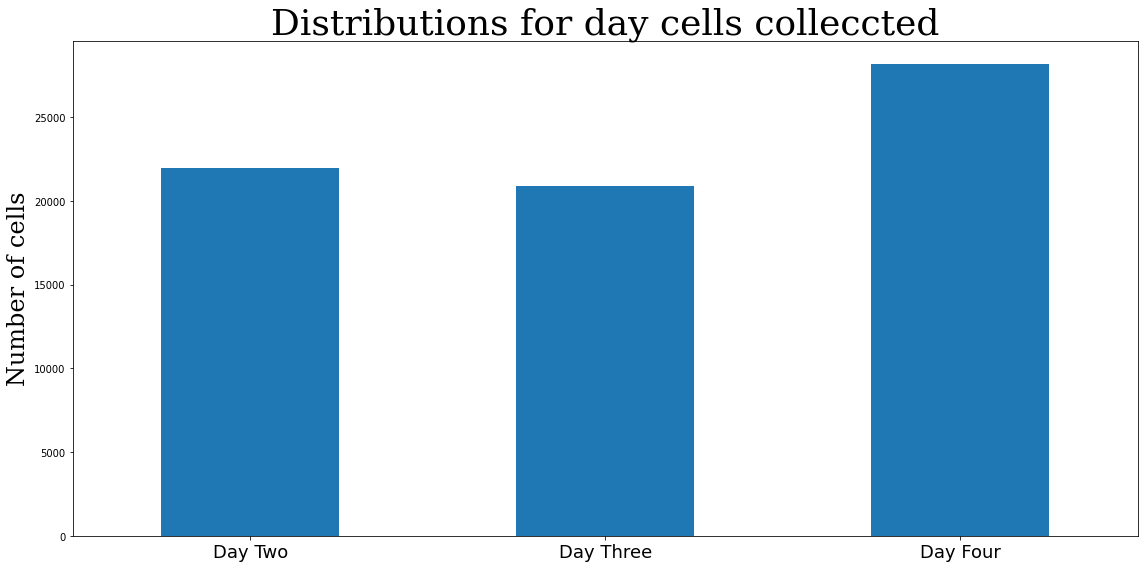

In [19]:
fig, ax = plt.subplots(figsize = (16, 8), tight_layout = True)
meta['day'].value_counts(sort = False).plot(kind = 'bar')
ax.set_xticklabels(['Day Two', 'Day Three', 'Day Four'], size = 18)
ax.set_title('Distributions for day cells colleccted', fontdict = font_title_defaults)
ax.set_ylabel('Number of cells', fontdict = font_ylabel_defaults)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
fig.savefig('./figures/dist_of_day.png');

There are 3 different days data was recorded from. Cells being processed by the system developed by Geonomics 10X can be handled in several ways. It is possible that these cells were collected and then within the next day populations of cells were run through the data recording process. More likely though cells were frozen and this clock began upon there being thawed. These cells would be kept alive in the lab and populations fromn the total sample would be processed, the technique involved destroys the cell. Here we can see that the distribution is fairly similar for cells processed across all the days.

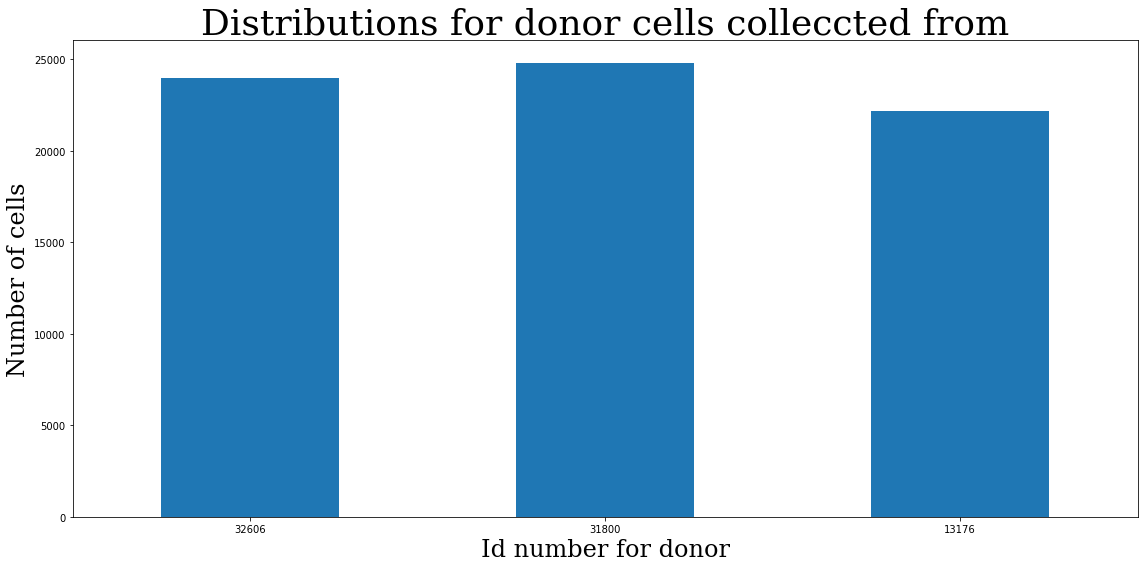

In [20]:
fig, ax = plt.subplots(figsize = (16, 8), tight_layout = True)
meta['donor'].value_counts(sort = False).plot(kind = 'bar')
ax.set_xlabel('Id number for donor', fontdict = font_xlabel_defaults)
ax.set_title('Distributions for donor cells colleccted from', fontdict = font_title_defaults)
ax.set_ylabel('Number of cells', fontdict = font_ylabel_defaults)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
fig.savefig('./figures/dist_of_donor.png');

Cells were sampled from three donors in about equal measure.

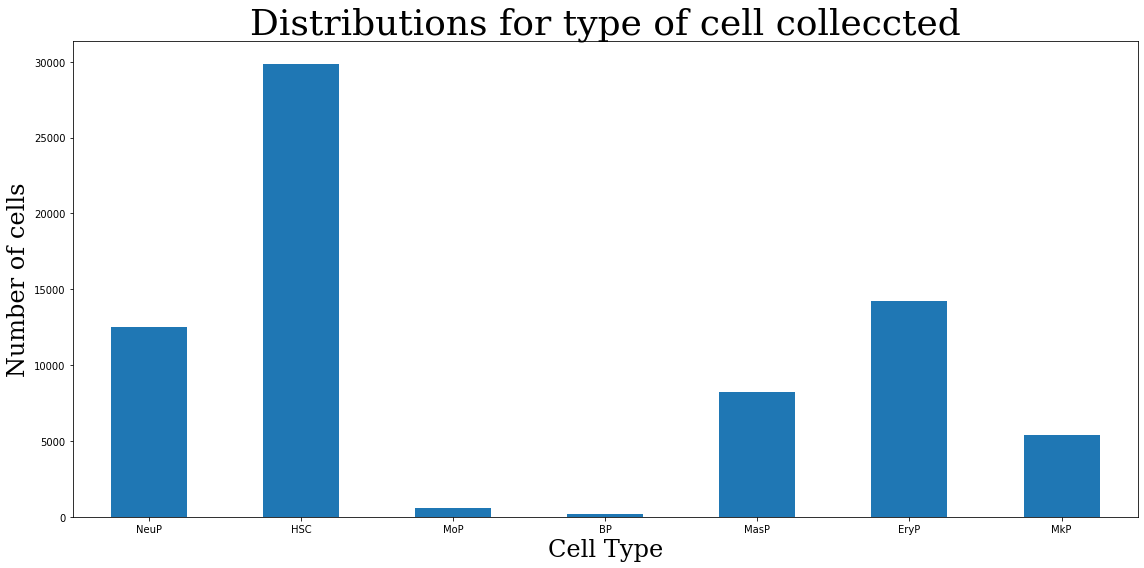

In [21]:
fig, ax = plt.subplots(figsize = (16, 8), tight_layout = True)
meta['cell_type'].value_counts(sort = False).plot(kind = 'bar')
ax.set_xlabel('Cell Type', fontdict = font_xlabel_defaults)
ax.set_title('Distributions for type of cell colleccted', fontdict = font_title_defaults)
ax.set_ylabel('Number of cells', fontdict = font_ylabel_defaults)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
fig.savefig('./figures/dist_of_cell_type.png');

The cell labels are defined as follows as reported in the kaggle competition data [documentation](https://www.kaggle.com/competitions/open-problems-multimodal/data).

- MasP = Mast Cell Progenitor
- MkP = Megakaryocyte Progenitor
- NeuP = Neutrophil Progenitor
- MoP = Monocyte Progenitor
- EryP = Erythrocyte Progenitor
- HSC = Hematoploetic Stem Cell
- BP = B-Cell Progenitor

The Kaggle competition hosts provided these labels, but they were derived as part of the host's own preprocessing and are not experimentally validated.
The main take away is that all these labels correspond to blood pregenitor cells, that is cells from which blood cells will be formed. This aligns with the data [description](https://www.kaggle.com/competitions/open-problems-multimodal/data), these cells were taken from bone marrow.

## Masks

In [22]:
proteins = meta.merge(proteins, how = 'inner', right_index = True, left_index = True)

In [23]:
day_two = proteins['day'] == 2
day_three = proteins['day'] == 3
day_four = proteins['day'] == 4
proteins['day'].value_counts()

4    28145
2    21942
3    20901
Name: day, dtype: int64

How the population of cells changes overtime could be a valuable signal. I will filter the data on this property.

## EDA Visualizations

In [24]:
ss = StandardScaler()

The kaggle competition hosts applied their own preprocessing to the data. They applied two normalizations regiemes one to the transcriptome data (the gene), the other to the proteins. Therefore I will use Standard Scaler with my EDA to bring these data better into alignment. This is reasonable because prior to applying standard scaler the data was also uninterpretable.

### Functions

In [25]:
# Dependencies: matplot.lib, pandas
# This creates visualizations. It applies a specified mask to genetic data and produces a scatter plot.
# The figures are then saved.

def genes_v_proteins_by_day(genes, proteins, masks, title, xlabel, ylabel, figsize = (24, 8), legend_size = 18):
    day_two, day_three, day_four = masks
    
    fig, ax = plt.subplots(ncols = 2, figsize = figsize, tight_layout = True)

    ax[0].scatter(x = total_genes[day_two], y = total_proteins[day_two], color = 'tab:cyan', alpha = 0.2, label = 'Day 2')
    ax[0].scatter(x = total_genes[day_three], y = total_proteins[day_three], color = 'tab:green', alpha = 0.2, label = 'Day 3')
    ax[0].scatter(x = total_genes[day_four], y = total_proteins[day_four], color = 'tab:red', alpha = 0.2, label = 'Day 4')

    ax[0].set_title('Day Four to Day Two', fontdict = font_title_defaults)
    ax[0].set_xlabel(xlabel, fontdict = font_xlabel_defaults)
    ax[0].set_ylabel(ylabel, fontdict = font_ylabel_defaults)
    
    ax[1].scatter(x = total_genes[day_four], y = total_proteins[day_four], color = 'tab:red', alpha = 0.2, label = 'Day 4')
    ax[1].scatter(x = total_genes[day_three], y = total_proteins[day_three], color = 'tab:green', alpha = 0.2, label = 'Day 3')
    ax[1].scatter(x = total_genes[day_two], y = total_proteins[day_two], color = 'tab:cyan', alpha = 0.2, label = 'Day 2')

    ax[1].set_title('Day Two to Day Four', fontdict = font_title_defaults)
    ax[1].set_xlabel(xlabel, fontdict = font_xlabel_defaults)
    ax[1].set_ylabel(ylabel, fontdict = font_ylabel_defaults)
    
    # Reverses the order of labels, increase the size 
    # and changes the label opacity to 100% in the legned.
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [2, 1, 0]
    leg = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize = legend_size)
    for lh in leg.legendHandles:
        lh.set_alpha(1)

    fig.suptitle(title, fontdict = font_title_defaults, size = 48, fontweight = 'bold')
    
    save_title = '_'.join(title.split(' '))
    save_title = ''.join(save_title.split('\n'))
    fig.savefig('./figures/genes_v_proteins_by_day/' + save_title + '.png');

The code to change the opacity of the legend handles was found on this stack overfow [page](https://stackoverflow.com/questions/12848808/set-legend-symbol-opacity-with-matplotlib#:~:text=First%2C%20assign%20your%20legend%20to%20a%20variable%20when,of%20matplotlib%29%3A%20for%20lh%20in%20leg.legendHandles%3A%20lh._legmarker.set_alpha%20%281%29).

The code to reverse the order of the legend was found on this [here](https://www.statology.org/matplotlib-legend-order/).

The main thing I will be considering in this series of visualizations is how the presences of the genes in aggregate relate to the presence of protein content in aggregate.

### Relationship of quantity of proteins present to quantity of genes present

In [26]:
total_genes = genes.sum(axis = 1) 
total_genes = ss.fit_transform(total_genes.values.reshape(-1, 1))

total_proteins = proteins[proteins.columns[4:-1]].sum(axis = 1)
total_proteins = ss.fit_transform(total_proteins.values.reshape(-1, 1))

total_genes.shape[0], total_proteins.shape[0]

(70988, 70988)

My first strategy for aggregation of the genetic data is to sum the rows, these correspond to specific cells; thereby, aggregating the genetic data by how active a cells transcriptome is, how many segements of RNA are loose in the cytoplasm waiting to be transcribed. Then as promised I will standard scale the data.

#### Distribution of protein present by cells

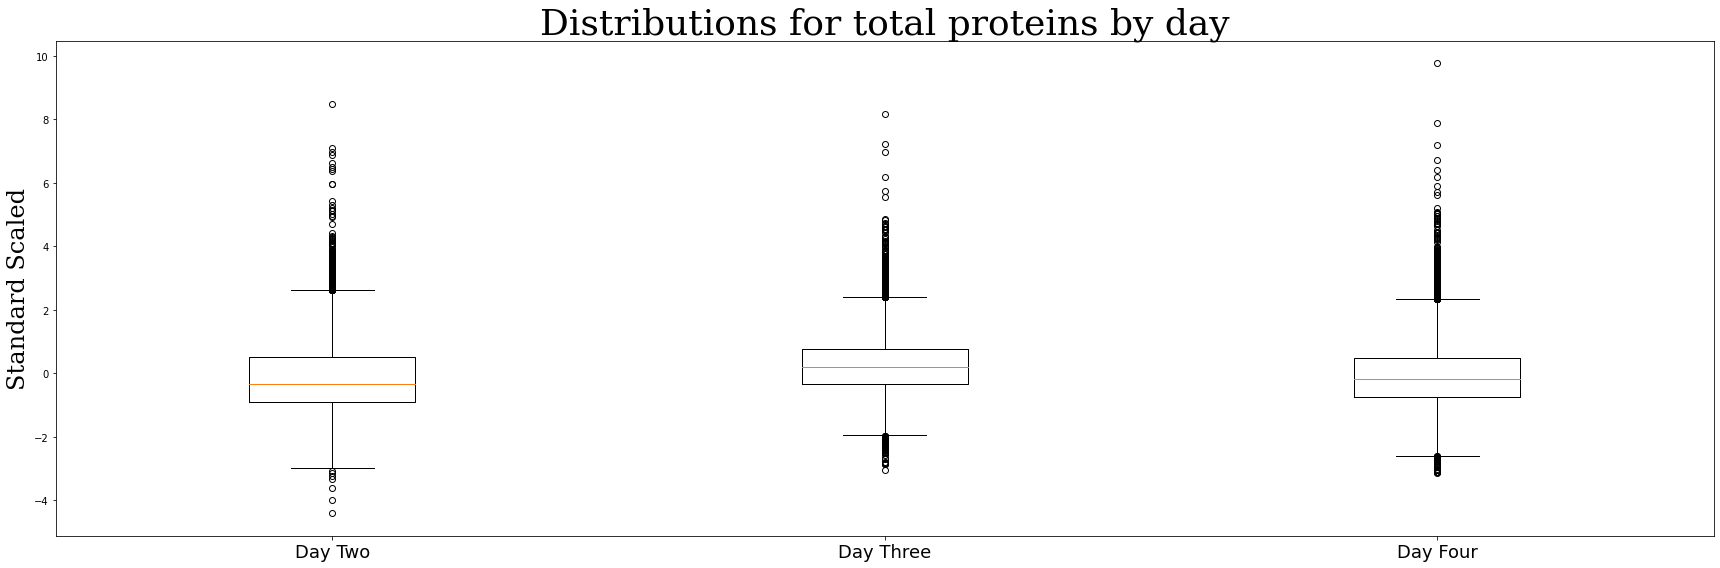

In [27]:
fig, ax = plt.subplots(figsize = (24, 8), tight_layout = True)

ax.boxplot([total_proteins[day_two].flatten(), total_proteins[day_three].flatten(), total_proteins[day_four].flatten()])
ax.set_xticklabels(['Day Two', 'Day Three', 'Day Four'], size = 18)
ax.set_title('Distributions for total proteins by day', fontdict = font_title_defaults)
ax.set_ylabel('Standard Scaled', fontdict = font_ylabel_defaults)
fig.savefig('./figures/genes_v_proteins_by_day/' + 'Distributions for total proteins by day' + '.png');

Under this aggregation strategy there is not much difference between the days with respect to total proteins measured.

#### Distribution of genetic material present by cells

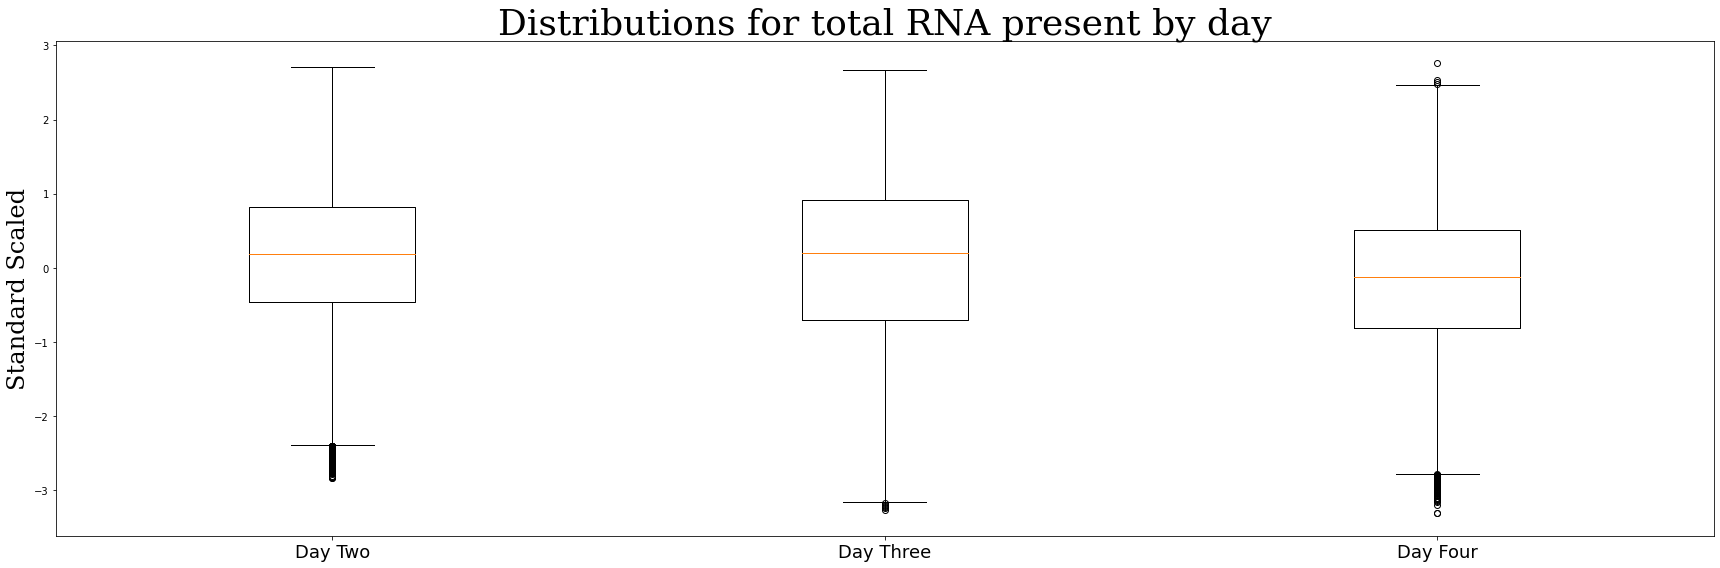

In [28]:
fig, ax = plt.subplots(figsize = (24, 8), tight_layout = True)

ax.boxplot((total_genes[day_two].flatten(), total_genes[day_three].flatten(), total_genes[day_four].flatten()))
ax.set_xticklabels(['Day Two', 'Day Three', 'Day Four'], size = 18)
ax.set_title('Distributions for total RNA present by day', fontdict = font_title_defaults)
ax.set_ylabel('Standard Scaled', fontdict = font_ylabel_defaults)
fig.savefig('./figures/genes_v_proteins_by_day/' + 'Distributions for total RNA present by day' + '.png');

In like manner, under this aggregation strategy there is not much difference between the days with respect to total amount of RNA measured.

#### Plot of quantity of proteins present to quantity of genes present

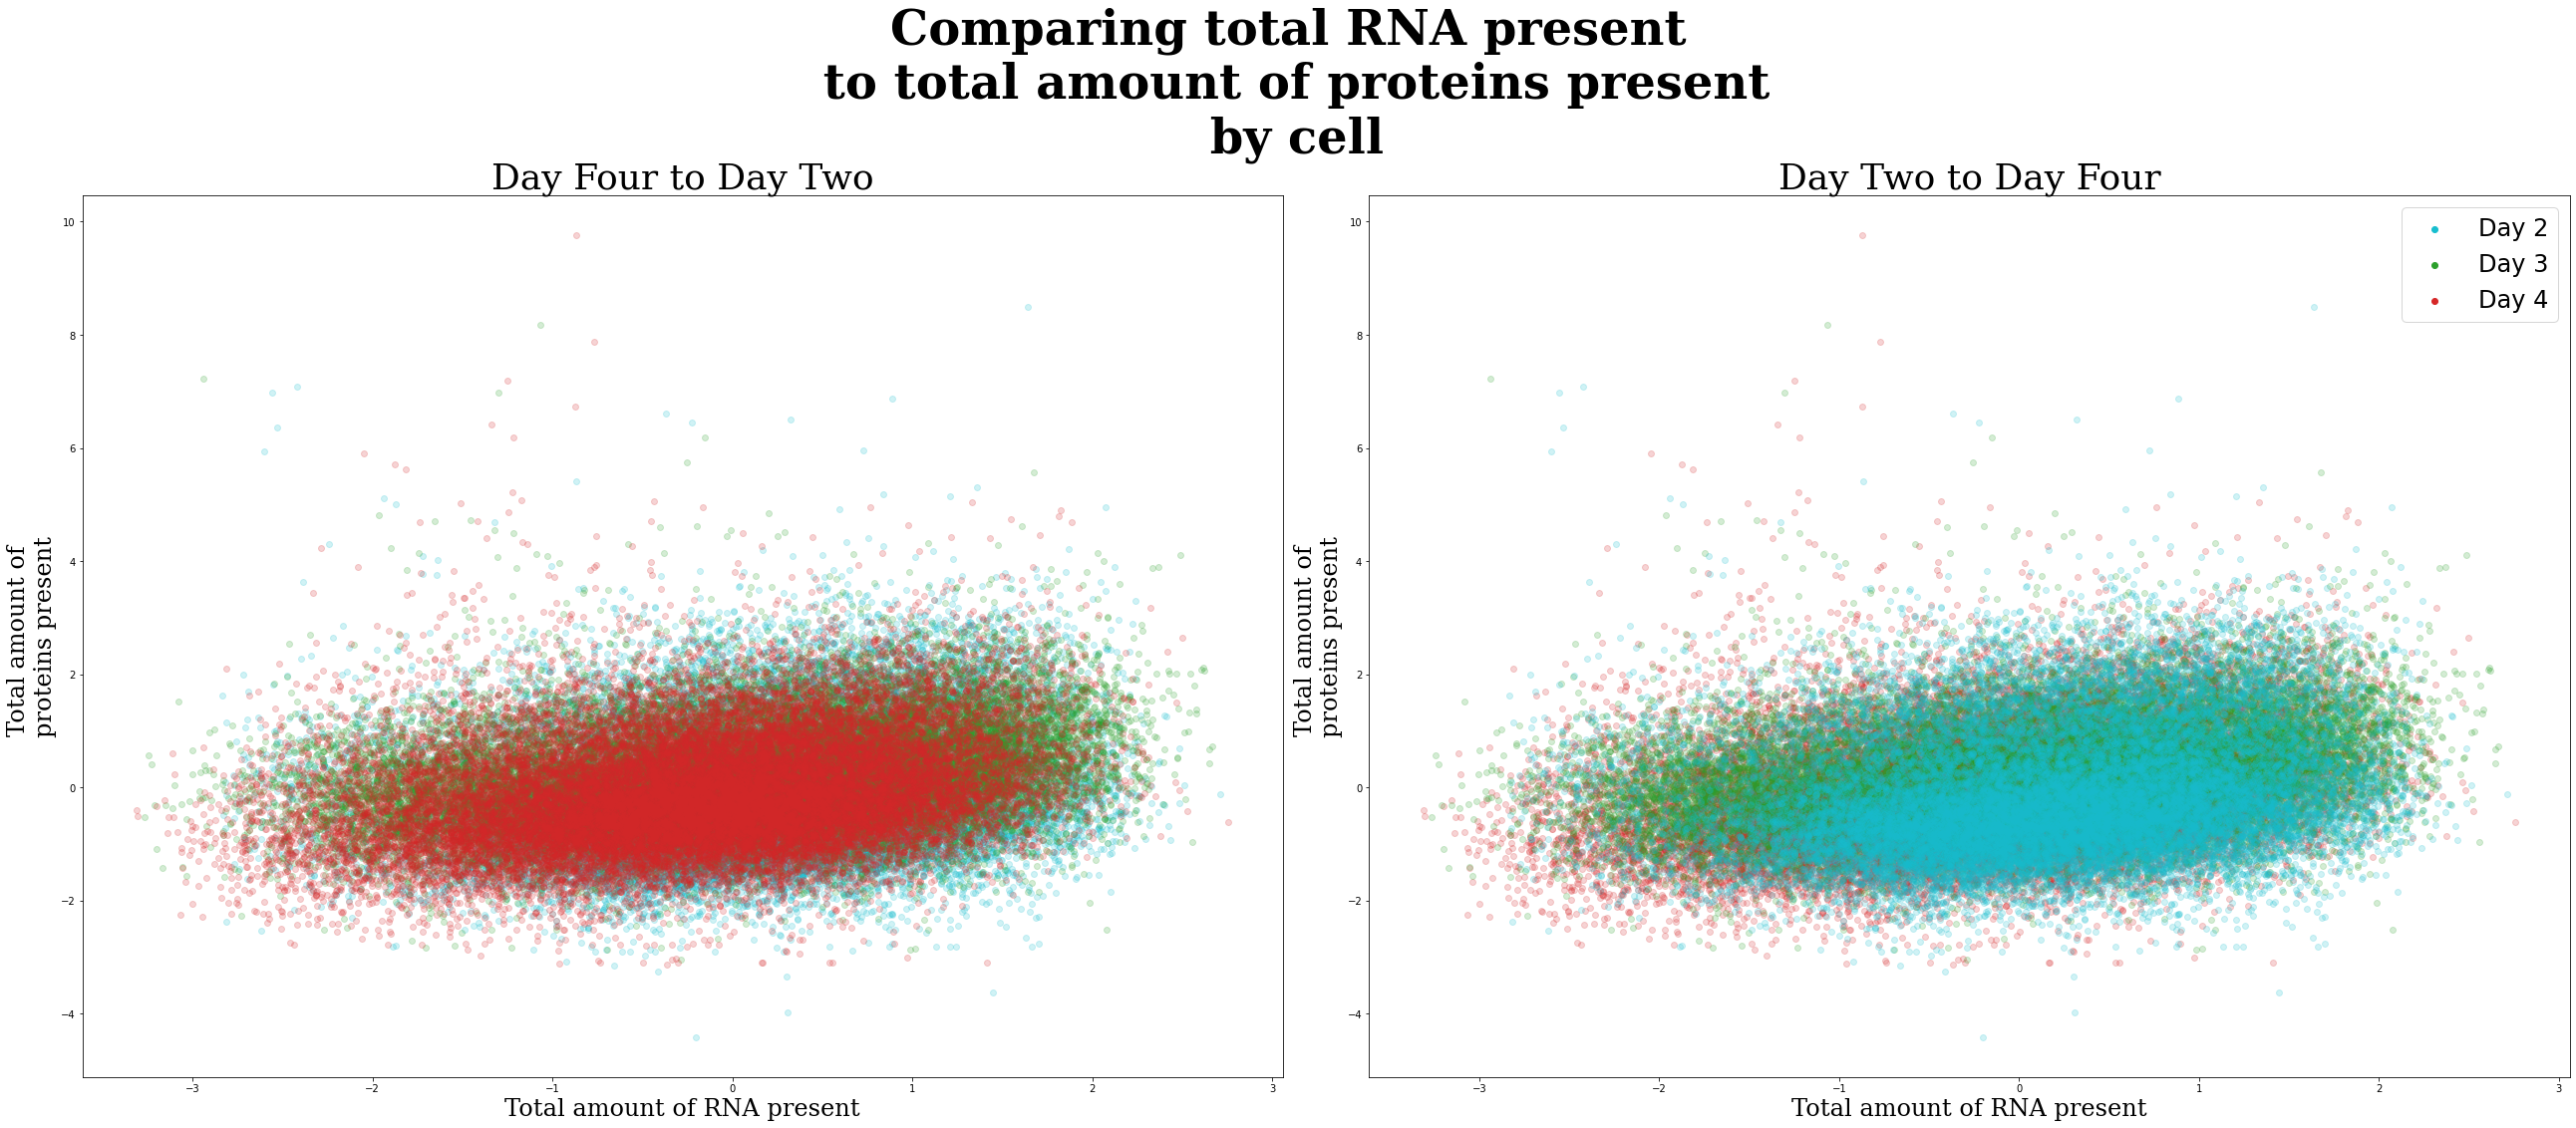

In [29]:
genes_v_proteins_by_day(genes = total_genes, 
                        proteins = total_proteins, 
                        masks = [day_two, day_three, day_four], 
                        title = 'Comparing total RNA present\n to total amount of proteins present\n by cell',
                        xlabel = 'Total amount of RNA present',
                        ylabel = 'Total amount of \nproteins present',
                        figsize = (36, 16),
                        legend_size = 24)

These are plots of total protein amount present in a cell's outer membrane versus total amount of RNA strands in a cell's cytoplasm. I provided two plots layering the data points by day first forward then backward in time. Essentially showing both sides of this plot. I think there are two main take-aways. This plot has a slight upward trend showing that cells with more RNA present in their cytoplasm are more likely to have more proteins studding the outer surface of their cellular membranes. Also as time progresses the distribution of the points seems to spread, the variation increases..

### Relationship of quantity of proteins present to quantity of most common type of RNA present

Now I will consider cells by the gene they most frequently transcribe. I will use the same aggregation method for proteins. But for the genes I will consider the RNA sequence that most frequently appears in each cell and use that.

In [30]:
total_genes = genes.max(axis = 1) 
total_genes = ss.fit_transform(total_genes.values.reshape(-1, 1))

total_proteins = proteins[proteins.columns[4:-1]].sum(axis = 1)
total_proteins = ss.fit_transform(total_proteins.values.reshape(-1, 1))

total_genes.shape[0], total_proteins.shape[0]

(70988, 70988)

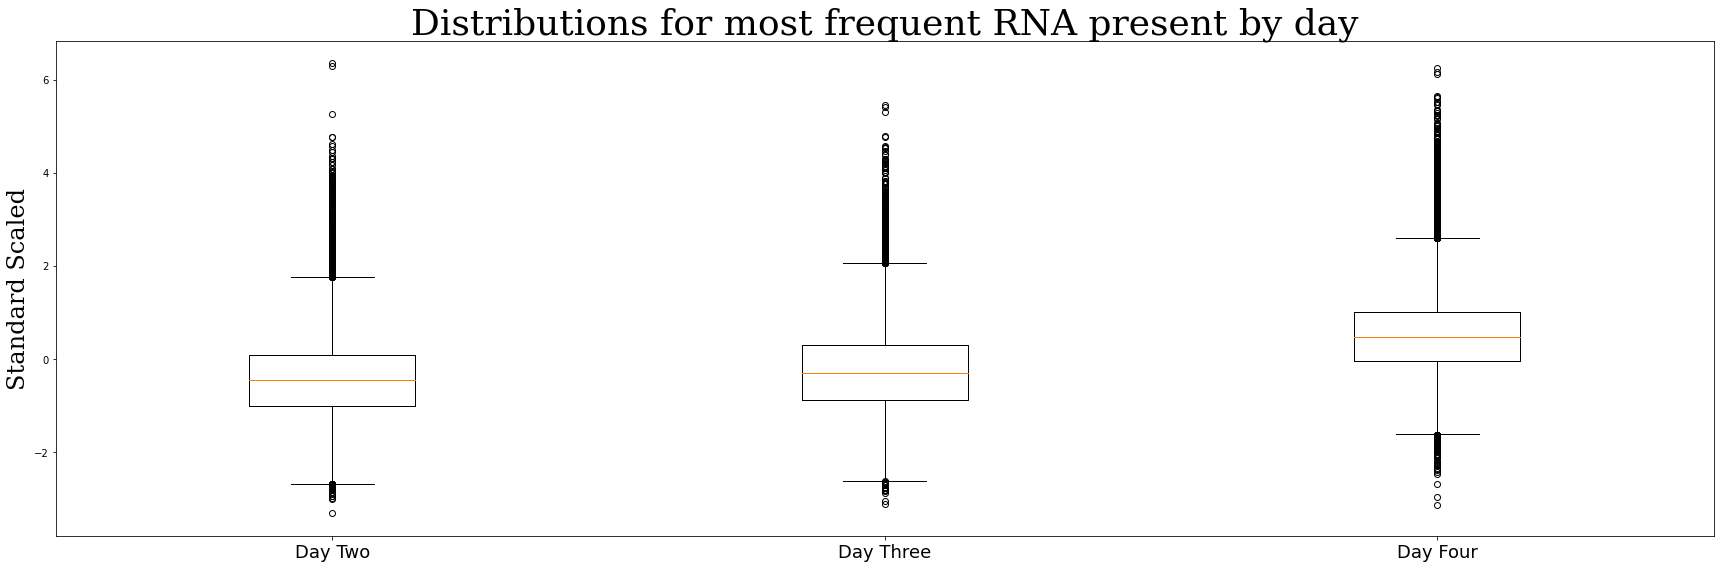

In [31]:
fig, ax = plt.subplots(figsize = (24, 8), tight_layout = True)

ax.boxplot((total_genes[day_two].flatten(), total_genes[day_three].flatten(), total_genes[day_four].flatten()))
ax.set_xticklabels(['Day Two', 'Day Three', 'Day Four'], size = 18)
ax.set_title('Distributions for most frequent RNA present by day', fontdict = font_title_defaults)
ax.set_ylabel('Standard Scaled', fontdict = font_ylabel_defaults)
fig.savefig('./figures/genes_v_proteins_by_day/' + 'Distributions for most frequent RNA present by day' + '.png');

We can see even from here that there is a slight distribution change. As time goes goes on, the amount of genetic material most frequently transcribed increases.

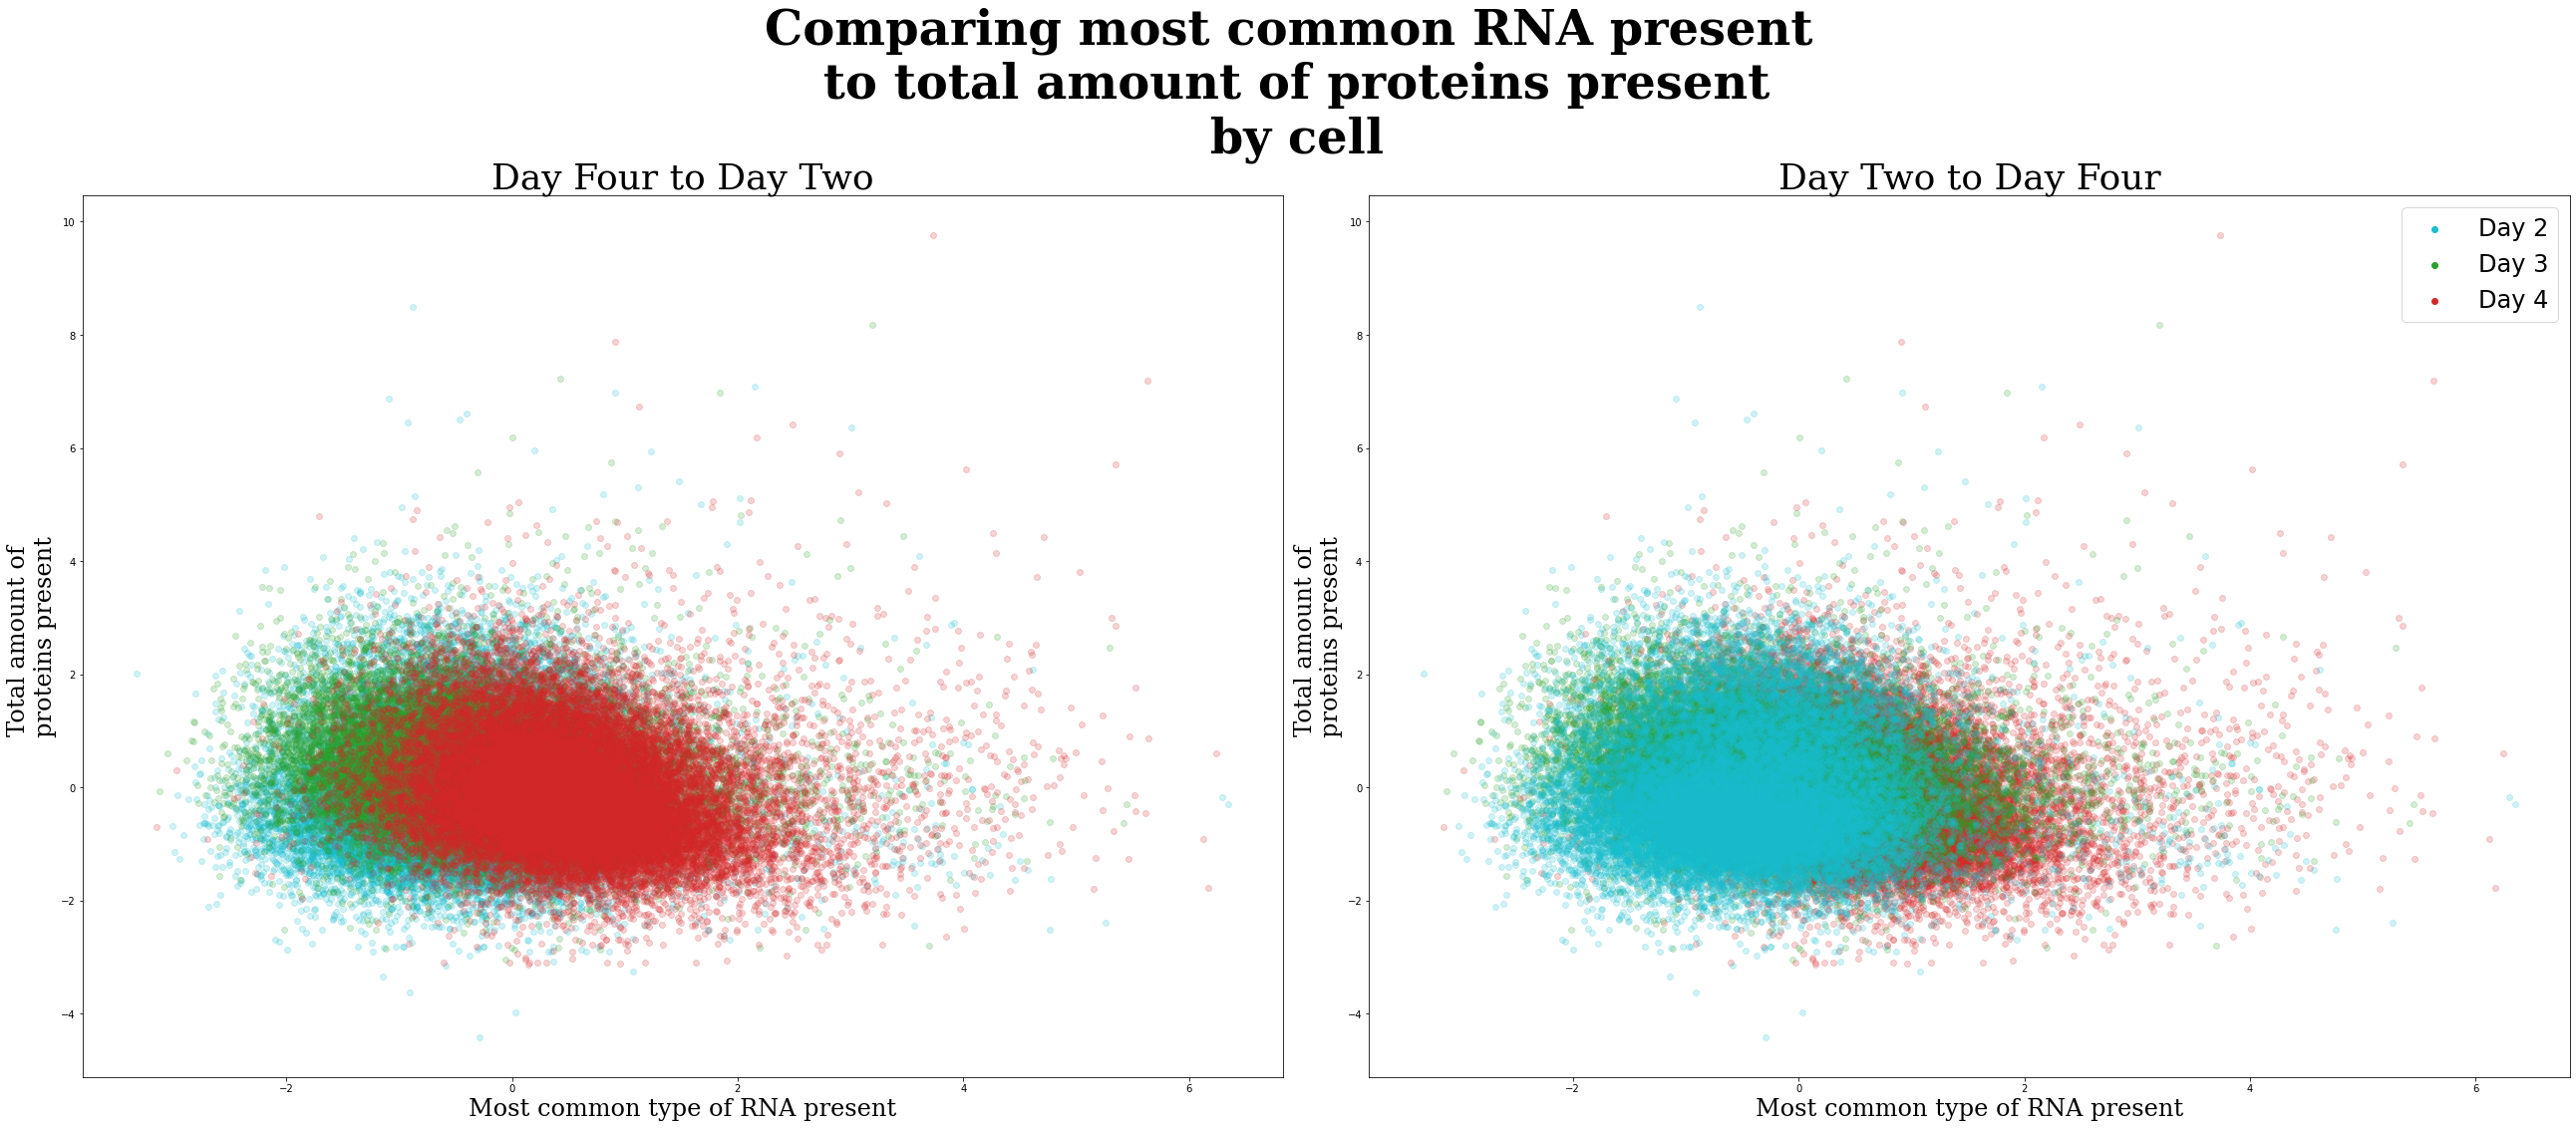

In [32]:
genes_v_proteins_by_day(genes = total_genes, 
                        proteins = total_proteins, 
                        masks = [day_two, day_three, day_four], 
                        title = 'Comparing most common RNA present\n to total amount of proteins present\n by cell',
                        xlabel = 'Most common type of RNA present',
                        ylabel = 'Total amount of \nproteins present',
                        figsize = (36, 16),
                        legend_size = 24)

Here we can see this trend we encountered when considering the most frequent RNA distribution much more clearly. Whatever the cell made during day two, there is more of it present later. One thing to remember concerning what is meant by day is that these cells are kept alive in a laboratory environment. On day one, they started to thaw so that they were ready to be processed on day two. A sampling was taken from this collection of cells, and they were processed; this includes those cells’ destruction. I describe the exact details more in a summary write-up within this repo.

Given this, I think we are seeing the consequences of cells not being within their typical cellular environment and not receiving any extracellular signaling that would otherwise be present. Essentially, the genes they had been transcribing the most are the ones they are still making. Another trend I am seeing is that the distribution is tight on the first recorded day and even centered around some mean point. But as we progressed in time, some of these cells started having much fewer proteins in their cell membranes. Another important detail is that, on all days, the more genetic material of a given RNA sequence does not lead to a discernable increase in overall protein presence; in later days, there is a downward trend.

Depending on the rate of RNA degradation, the cells could be increasing the rate of transcribing this gene, or there is a build-up of this type of RNA sequence in the cellular cytoplasm, and the cell is not equipped to handle this. Given that we see in the later days a downward trend in the amount of protein as the amount of the given type of RNA sequence increases, I expect the last hypothesis to be more likely.

My overall takeaway is that cellular behavior changes as they experience life in a laboratory rather than living in tissue. They get stuck doing the same thing as there is no force in their environment to direct their behavior. The cells are degrading and producing more transcribed RNA, but this is not translating to more proteins present in their cellular membranes but fewer.

In the future, I think this graph could be used to evaluate the quality of the cells. A way to filter the cells to the ones better at training a model and less affected by the noise of being in an environment, unlike their natural state.


### Relationship of quantity of proteins present to quantity of most types of RNA present most common across the entire population of cells

This aggregation process is similar to the previous one but also differnet in really important ways. The previous method concerned itself with the most common type of RNA in a given cell. This method is concerned with the most common types of RNA across the entire sample of cells. (It is worth mentioning that I had designed this aggregation method to increase support for the same findings in the previous one. But I was suprised to find the graphs essentially look like the opposite of each other. That there is such a difference in the effect of RNA frequency by cell versus across the whole population of cells is a )

In [33]:
just_proteins = proteins.drop(columns = ['cell_type', 'day', 'donor'])

cut_off = genes.sum(axis = 0).sort_values(ascending = False).quantile(.95)

some_genes = genes.columns[genes.sum(axis = 0) >= cut_off]

some_genes = genes[some_genes]

total_genes = some_genes.sum(axis = 1) 
total_genes = ss.fit_transform(total_genes.values.reshape(-1, 1))

total_proteins = just_proteins.sum(axis = 1)
total_proteins = ss.fit_transform(total_proteins.values.reshape(-1, 1))

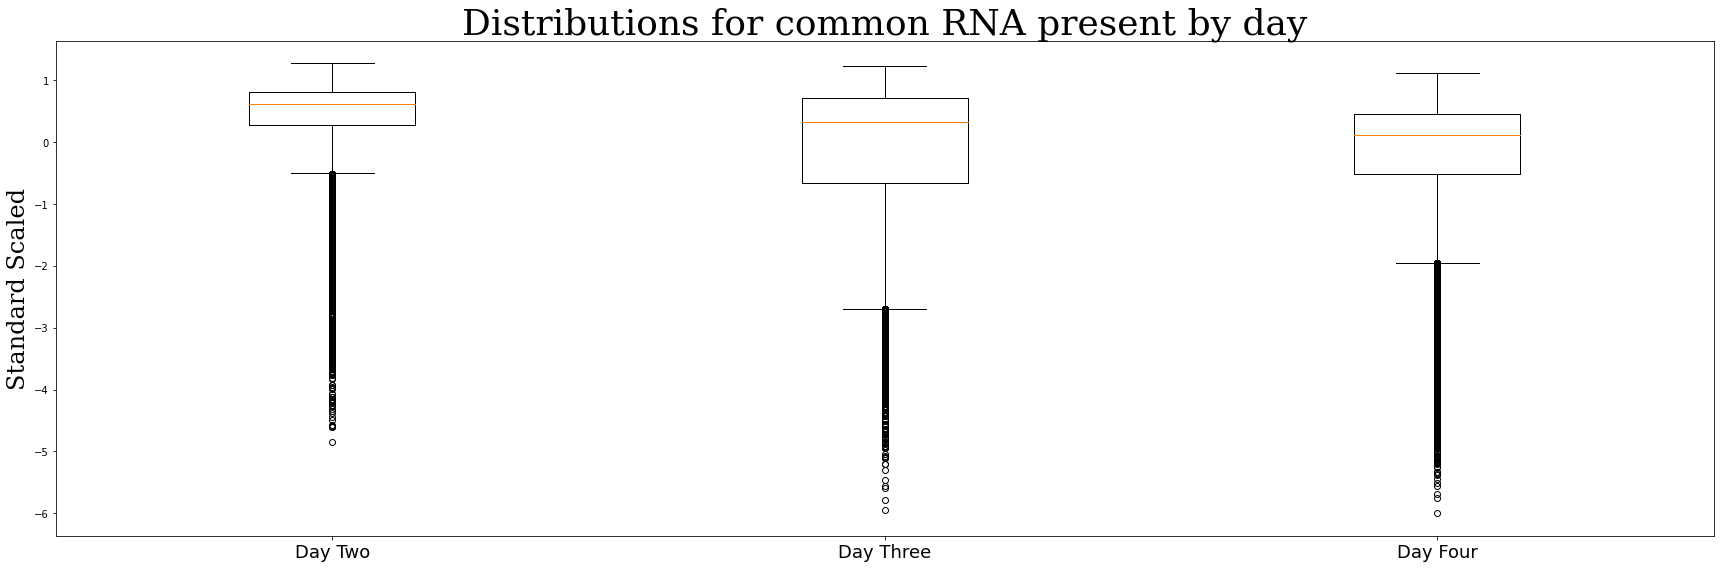

In [34]:
fig, ax = plt.subplots(figsize = (24, 8), tight_layout = True)

ax.boxplot((total_genes[day_two].flatten(), total_genes[day_three].flatten(), total_genes[day_four].flatten()))
ax.set_xticklabels(['Day Two', 'Day Three', 'Day Four'], size = 18)
ax.set_title('Distributions for common RNA present by day', fontdict = font_title_defaults)
ax.set_ylabel('Standard Scaled', fontdict = font_ylabel_defaults)
fig.savefig('./figures/genes_v_proteins_by_day/' + 'Distributions for common RNA present by day' + '.png');

These data have the opposite distribution from the graph before. RNA material steps down over time. On day three, this is facilitated by an expansion of the range of the distribution's core. But by day four, the cells that were lagging in the decrease of RNA seemed to be catching up with their peers, so the distribution's range had shrunk by day four.

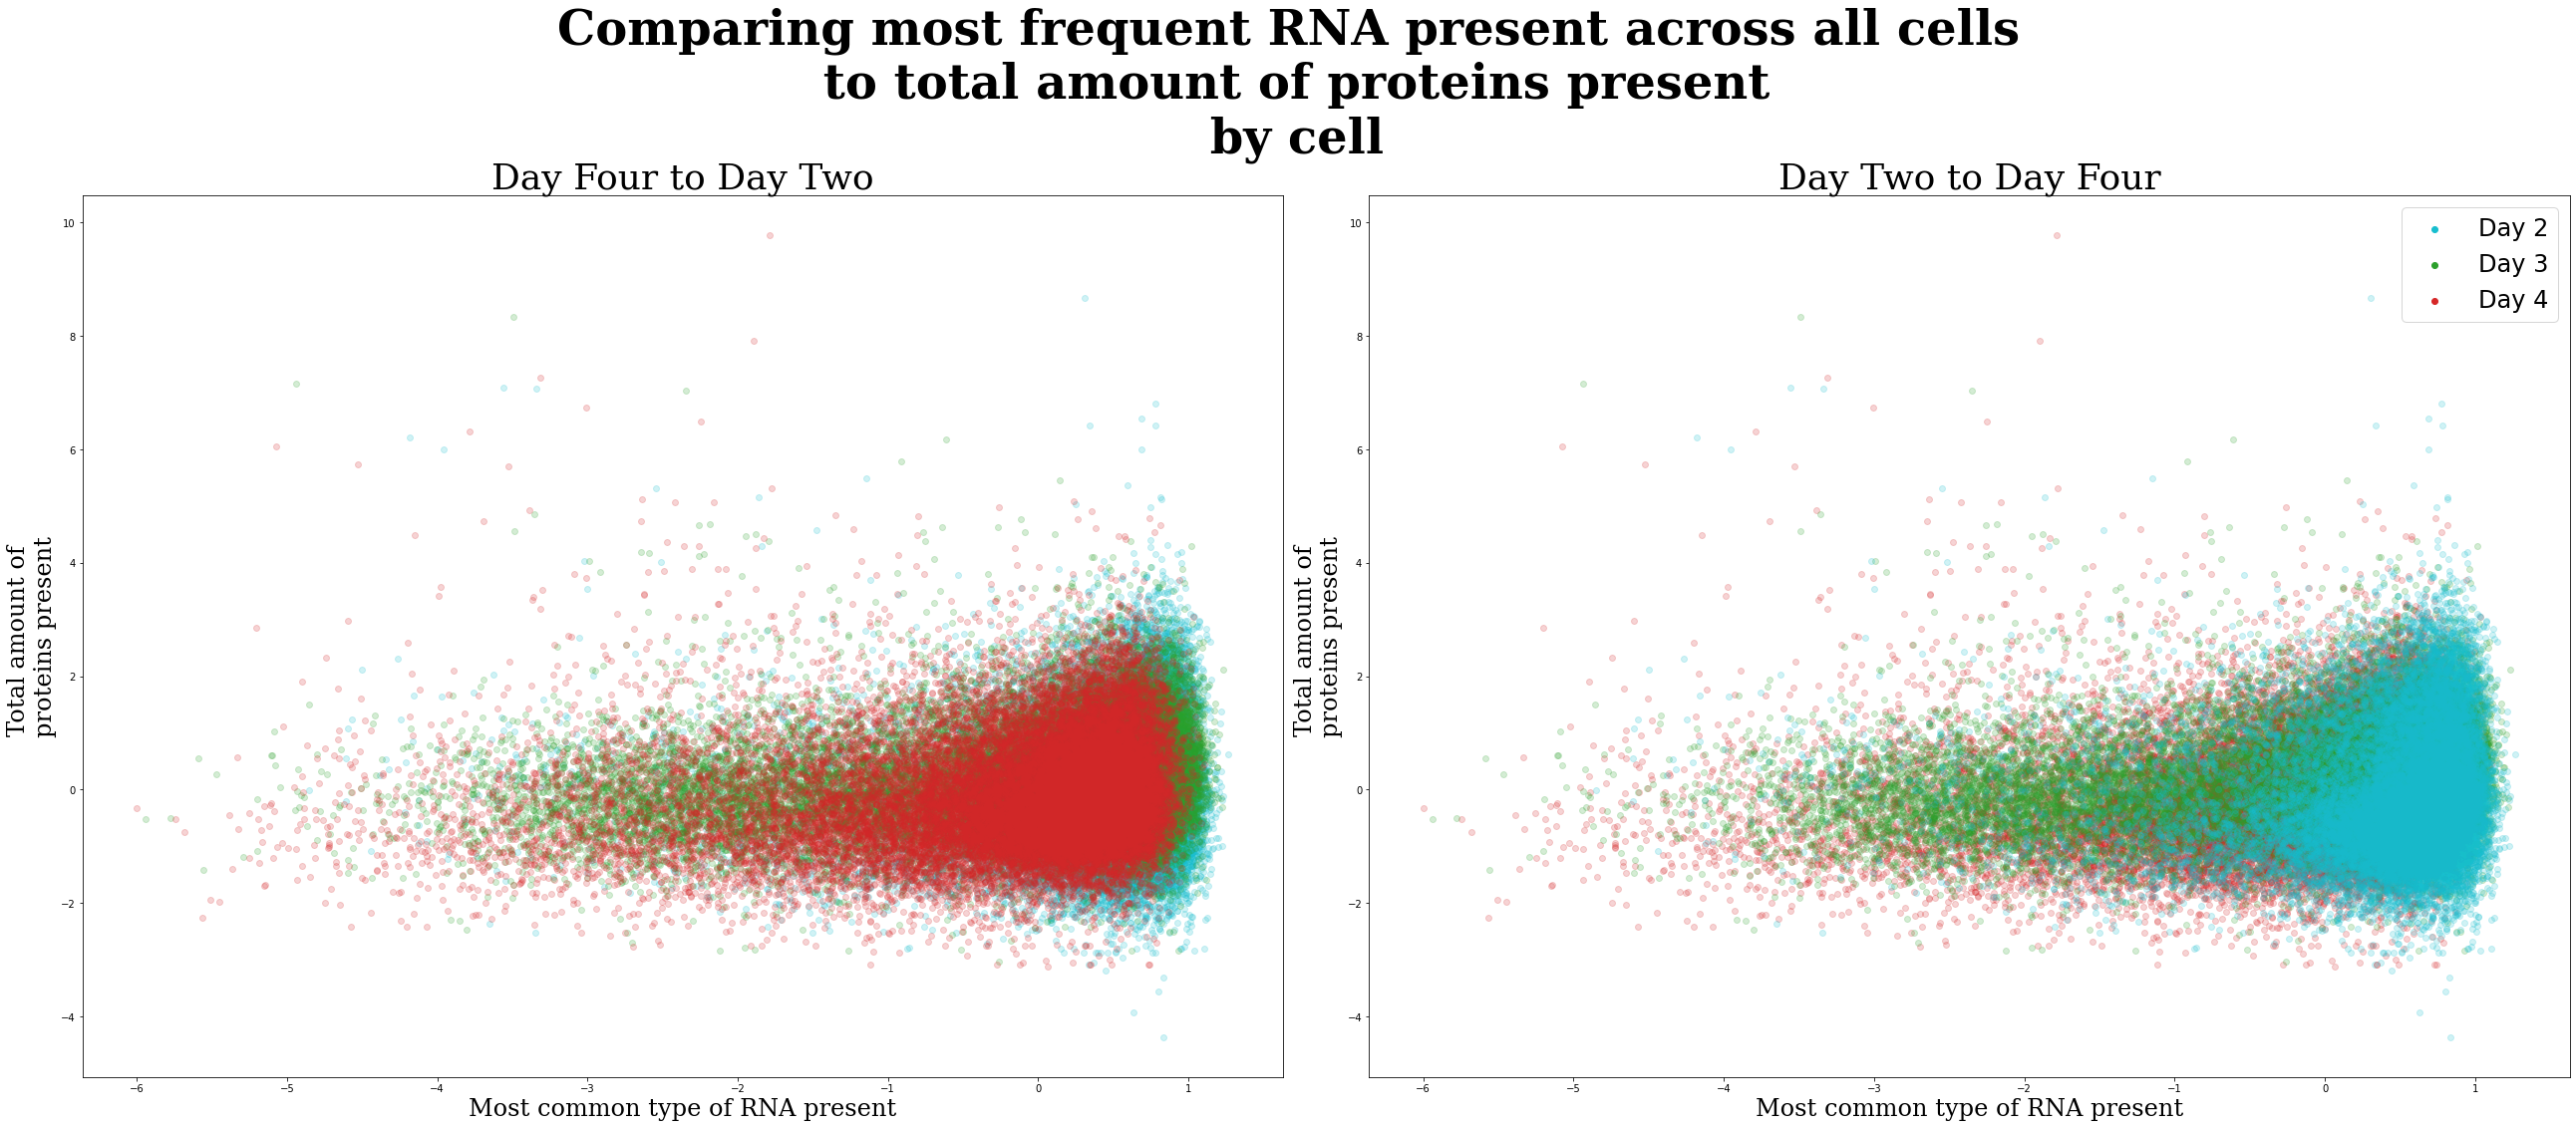

In [35]:
genes_v_proteins_by_day(genes = total_genes, 
                        proteins = total_proteins, 
                        masks = [day_two, day_three, day_four], 
                        title = 'Comparing most frequent RNA present across all cells\n to total amount of proteins present\n by cell',
                        xlabel = 'Most common type of RNA present',
                        ylabel = 'Total amount of \nproteins present',
                        figsize = (36, 16),
                        legend_size = 24)

The first thing to recognize is which genes are being considered here. They are the genes that are most common across all cells. That means they are essential for cells in general. This population of genes is known to be primarily composed of mitochondrial and ribosomal genes. Mitochondria are "the power-house of the cell"; to some extent, the presence of these genes is a proxy for a cell's metabolism. At the same time, the ribosome is responsible for translating the RNA into proteins. Both gene types are related to a cell's metabolism and correspond to how the cell’s activity changes. This is different from the population of genes we were considering in the graph before, those genes related to the specific activity of the cell as distinct from its neighbors. In contrast, these genes are a proxy for cellular activity and are consistently expressed across all cells.

On day two, we see a tight clump within the positive side of the graph. (The data was standard scaled, so negative vs. positive values only show what side of the mean the cell's normalized quantity of genetic material is on.) On day three, this expands, and we see a long tail of cells producing much less genetic material related to cellular function. By day four, there is a clear downward step; essentially, no cell is as active as the cells measured on day two. This seems to suggest a rate at which cells die and become less active.

Another critical factor is that though the distributions for the genetic quantities shown in the graph are standard scaled, there is a long tail. This means that the cells producing more genetic material of this type than the mean are similar. But the possible state space for these dying cells whose genetic material of this type is below the mean varies wildly from each other. That day two has a minimal tail suggests that this widely uneven distribution is not natural for cells within normal living tissue.

## Conclusions

From these graphs I can get a sense of cell quality. I think these graphs are showing that this population of cells is dying. Fitting models on the dying cells likely will produce far less insight into the underlying dynamics of the cellular biology that the field of single cell data science is interested in. Therefore I will focus my models on day two.

## Next Steps

The names for each of these genes can be searched using any internet search engine. Many websites include more data on these genes. This includes if a gene is non-coding or coding. When transcribed to RNA, some genes never go on to produce proteins but perform some other activity as RNA. This may even include the promotion of the transcription of other genes. These websites also have information about introns and exons. When an RNA is transcribed from DNA, it undergoes additional processing before exiting the nucleus. This can include excising exons from within the RNA sequence such that later when proteins are transcribed from this sequence these proteins could differ depending on which exons are excised at this step. This information could be very useful in filtering the importance of these various genes when predicting specific proteins.

One website Ensembl, is free and includes a Restful API. I would like to have its information in this kind of EDA in future work.